# CNN: Regression experiments

script: jupyter-gpu.sbatch  
partition: gpu  
conda env: torch-ni-ny  
data: /scratch/groups/jyeatman/samjohns-projects/data 
  
notable changes:
- add train-test split
- (network) add extra final fully connected layer
- (network) change fc nonlinearity from relu to elu

## Step 1: Prepare Data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# these are required for defining the regession ImageFolder
from typing import Dict, Any
from torchvision import datasets

import pandas as pd
import numpy as np

In [2]:
import os, sys, pickle

import struct
from array import array
from os import path

import png
from PIL import Image
from PIL import ImageOps

In [3]:
# user-defined helper functions for visualization and training
import user

In [4]:
from user.data import ToFloat, ToRGB, CustomImageDataset

In [5]:
proj_dir = '/scratch/groups/jyeatman/samjohns-projects'
# image_subdir = '/data/fsa-data/images/images-thickness-sphere-processed'
image_subdir = '/data/fsa-data/images/nojitter-curv-sphere-processed'
image_dir = proj_dir + image_subdir
os.chdir(proj_dir)

In [6]:
# dataset specific directories
data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
pheno_dir = '/scratch/groups/jyeatman/samjohns-projects/data/hbn-reading-age-data'
label_dir = data_dir + '/labels'
os.listdir(pheno_dir)

['agef.pkl',
 'wiat_reading.csv',
 'nonblank_inds.pkl',
 'hbn_ages_blanks.csv',
 'readf.pkl']

# This section formats the dataset
- It is unnecessary to execute unless preparing a new dataset
- (In which case, new image directories, pheno files, and label output files should be set)

In [7]:
# first read in filenames and create a filename dataframe

image_filenames = os.listdir(image_dir)

In [8]:
# strip EID from image filenames; first 16 characters of filename string
EID_length = 16
sub_filenames = [name[:EID_length] for name in image_filenames]
assert len(sub_filenames) == len(image_filenames)

In [9]:
d = {'EID': sub_filenames, 'Filename': image_filenames}

In [10]:
filename_df = pd.DataFrame(d)

In [11]:
filename_df.head()

,EID,Filename
0,sub-NDARGY622NG6,sub-NDARGY622NG6.fsa.lh.curv--65.00-0.00-0.00.png
1,sub-NDARLE282UHJ,sub-NDARLE282UHJ.fsa.lh.curv--65.00-0.00-0.00.png
2,sub-NDARDD854GF8,sub-NDARDD854GF8.fsa.lh.curv--65.00-0.00-0.00.png
3,sub-NDARRC348AFG,sub-NDARRC348AFG.fsa.lh.curv--65.00-0.00-0.00.png
4,sub-NDARAT709MMX,sub-NDARAT709MMX.fsa.lh.curv--65.00-0.00-0.00.png


In [17]:
read_df = pd.read_csv(pheno_dir+'/wiat_reading.csv', header=None)

In [18]:
read_df.columns = ['EID', 'Read']
read_df.head()

,EID,Read
0,sub-NDARAA075AMK,146.0
1,sub-NDARAA536PTU,123.0
2,sub-NDARAA948VFH,96.0
3,sub-NDARAB055BPR,98.0
4,sub-NDARAB348EWR,123.0


In [20]:
read_df_noblanks = read_df[read_df.Read != ' ']

In [21]:
pheno_df = pd.merge(filename_df, read_df_noblanks, on='EID', how='left')

In [22]:
# filter out nan's (for which EID didn't appear in Age data)
pheno_df = pheno_df.dropna()

In [23]:
pheno_df.head()

,EID,Filename,Read
0,sub-NDARGY622NG6,sub-NDARGY622NG6.fsa.lh.curv--65.00-0.00-0.00.png,54.0
2,sub-NDARDD854GF8,sub-NDARDD854GF8.fsa.lh.curv--65.00-0.00-0.00.png,119.0
6,sub-NDAREU591YYA,sub-NDAREU591YYA.fsa.lh.curv--65.00-0.00-0.00.png,109.0
10,sub-NDARBL532FPT,sub-NDARBL532FPT.fsa.lh.curv--65.00-0.00-0.00.png,106.0
11,sub-NDARJA157YB3,sub-NDARJA157YB3.fsa.lh.curv--65.00-0.00-0.00.png,101.0


In [25]:
len(pheno_df)

1423

In [26]:
# save df as .csv
label_dir = data_dir + '/labels'
if not os.path.exists(label_dir):
    os.makedirs(label_dir)
pheno_df_nosub = pheno_df[['Filename', 'Read']]
pheno_df_nosub

,Filename,Read
0,sub-NDARGY622NG6.fsa.lh.curv--65.00-0.00-0.00.png,54.0
2,sub-NDARDD854GF8.fsa.lh.curv--65.00-0.00-0.00.png,119.0
6,sub-NDAREU591YYA.fsa.lh.curv--65.00-0.00-0.00.png,109.0
10,sub-NDARBL532FPT.fsa.lh.curv--65.00-0.00-0.00.png,106.0
11,sub-NDARJA157YB3.fsa.lh.curv--65.00-0.00-0.00.png,101.0
...,...,...
2378,sub-NDARYZ637LK4.fsa.lh.curv--65.00-0.00-0.00.png,81.0
2383,sub-NDARTK834FT9.fsa.lh.curv--65.00-0.00-0.00.png,107.0
2384,sub-NDARRU729XRU.fsa.lh.curv--65.00-0.00-0.00.png,97.0
2385,sub-NDARCB627KDN.fsa.lh.curv--65.00-0.00-0.00.png,105.0


In [34]:
# note: important to specify index=False so that index is not added as first column
# this would lead to an unexpected format for CustomImageDataset
pheno_df_nosub.to_csv(label_dir+'/read_nojitter_curv_sphere_labels.csv', index=False)

In [28]:
os.listdir(label_dir)

['read_nojitter_curv_sphere_labels.csv',
 'age_labels.csv',
 'age_thickness_sphere_labels.csv']

In [29]:
readlabels = [x for x in os.listdir(label_dir) if 'read' in x][0]

In [30]:
readlabels

'read_nojitter_curv_sphere_labels.csv'

## Load MNIST dataset for testing, if desired
- optionally loads MNIST database for testing

In [9]:
# MNIST location
proj_dir = '/scratch/groups/jyeatman/samjohns-projects'
mnist_subdir = 'data/MNIST/mnist_png'
mnist_dir = os.path.join(proj_dir, mnist_subdir)
mnist_training_dir = os.path.join(mnist_dir, 'training')
mnist_testing_dir = os.path.join(mnist_dir, 'testing')

In [10]:
mnist_train = CustomImageDataset(f'{mnist_training_dir}/training_labels.csv', f'{mnist_training_dir}/all', transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())
mnist_test = CustomImageDataset(f'{mnist_testing_dir}/testing_labels.csv', f'{mnist_testing_dir}/all', transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())

NameError: name 'ToFloat' is not defined

In [ ]:
# for MNIST
mnist_batch_size = 64

mnist_trainloader = DataLoader(mnist_train, batch_size=mnist_batch_size, shuffle=True)
mnist_testloader = DataLoader(mnist_test, batch_size=mnist_batch_size, shuffle=False)

## Load dataset
- Continue from this point if images and label files are already created

In [7]:
readlabels = [x for x in os.listdir(label_dir) if 'read' in x][0]
# load labels to check for correct formatting
test_df = pd.read_csv(f'{label_dir}/{readlabels}')

In [8]:
test_df

,Filename,Read
0,sub-NDARGY622NG6.fsa.lh.curv--65.00-0.00-0.00.png,54.0
1,sub-NDARDD854GF8.fsa.lh.curv--65.00-0.00-0.00.png,119.0
2,sub-NDAREU591YYA.fsa.lh.curv--65.00-0.00-0.00.png,109.0
3,sub-NDARBL532FPT.fsa.lh.curv--65.00-0.00-0.00.png,106.0
4,sub-NDARJA157YB3.fsa.lh.curv--65.00-0.00-0.00.png,101.0
...,...,...
1418,sub-NDARYZ637LK4.fsa.lh.curv--65.00-0.00-0.00.png,81.0
1419,sub-NDARTK834FT9.fsa.lh.curv--65.00-0.00-0.00.png,107.0
1420,sub-NDARRU729XRU.fsa.lh.curv--65.00-0.00-0.00.png,97.0
1421,sub-NDARCB627KDN.fsa.lh.curv--65.00-0.00-0.00.png,105.0


In [9]:
# compute statistics of reading scores
m = test_df['Read'].mean()
s = test_df['Read'].std()
print(f'Mean: {m}, \nStandard Deviation: {s}')

Mean: 105.0203794799719, 
Standard Deviation: 15.81553316544752


In [10]:
# load total dataset
read_curv = CustomImageDataset(f'{label_dir}/{readlabels}', image_dir, transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())

In [11]:
# create random split into train and test sets
nsamples = len(read_curv)
indices = list(range(nsamples))
ntest = nsamples // 10
ntrain = nsamples - ntest
test_indices = list(np.random.choice(indices, size=ntest, replace=False))
train_indices = list(set(indices) - set(test_indices))
(len(test_indices), len(train_indices))

(142, 1281)

In [12]:
curv_read_train = torch.utils.data.Subset(read_curv, train_indices) 
curv_read_test = torch.utils.data.Subset(read_curv, test_indices) 

In [13]:
# create dataloaders for convenient batching
batch_size = 64

trainloader = DataLoader(curv_read_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
testloader = DataLoader(curv_read_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)

In [14]:
train_batch = next(iter(trainloader))

In [18]:
X, y = train_batch
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([64, 1, 200, 200]), torch.float32, torch.Size([64]), torch.float32)

Classes: tensor([ 95., 107., 121.,  71., 120.])


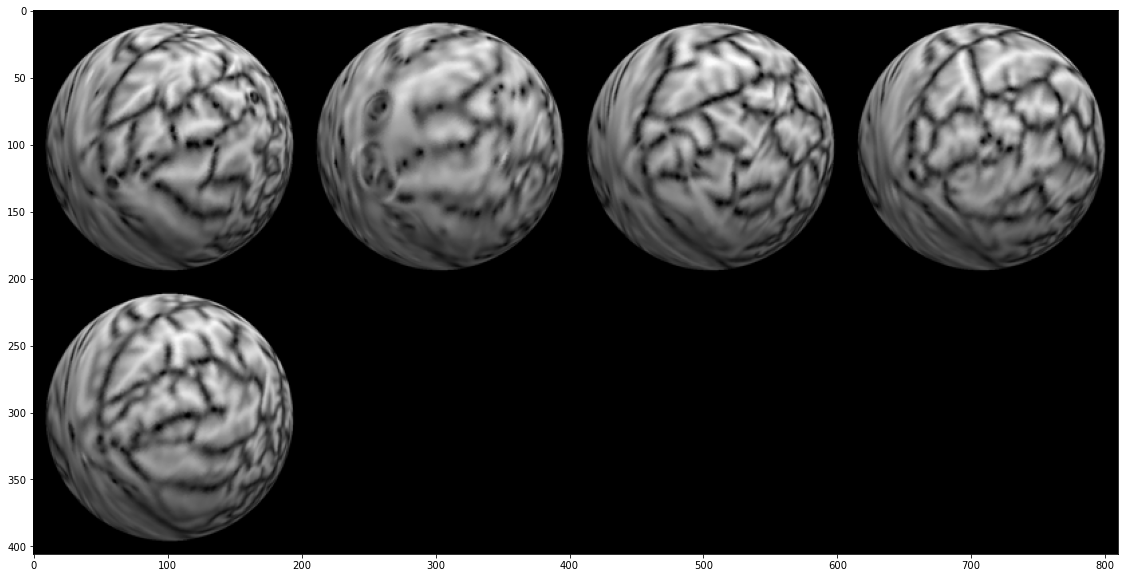

In [19]:
# visualize images

from user.utils import imshow

# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch (nrows images per row)
print(f'Classes: {classes[:5]}')
out = torchvision.utils.make_grid(inputs[:5], nrow=4)

imshow(out)

## Model training (for testing Freeview image CNN)

In [20]:
device = user.utils.get_device()
device

device(type='cuda', index=0)

In [21]:
from user.models import SmallConvNet

In [22]:
cnn = SmallConvNet()

In [23]:
cnn

SmallConvNet(
  (block1): ConvPoolBlock(
    (c1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvPoolBlock(
    (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): ConvPoolBlock(
    (c1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): ConvPoolBlock(
    (c1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxP

In [24]:
from torchsummary import summary
cnn.to(device)

SmallConvNet(
  (block1): ConvPoolBlock(
    (c1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvPoolBlock(
    (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): ConvPoolBlock(
    (c1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): ConvPoolBlock(
    (c1): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (c2): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (p): MaxP

In [25]:
summary(cnn, input_data=(1, 200, 200))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvPoolBlock: 1-1                     [-1, 64, 99, 99]          --
|    └─Conv2d: 2-1                       [-1, 32, 200, 200]        544
|    └─Conv2d: 2-2                       [-1, 64, 200, 200]        32,832
|    └─MaxPool2d: 2-3                    [-1, 64, 99, 99]          --
├─ConvPoolBlock: 1-2                     [-1, 128, 48, 48]         --
|    └─Conv2d: 2-4                       [-1, 128, 99, 99]         131,200
|    └─Conv2d: 2-5                       [-1, 128, 99, 99]         262,272
|    └─MaxPool2d: 2-6                    [-1, 128, 48, 48]         --
├─ConvPoolBlock: 1-3                     [-1, 128, 23, 23]         --
|    └─Conv2d: 2-7                       [-1, 128, 48, 48]         262,272
|    └─Conv2d: 2-8                       [-1, 128, 48, 48]         262,272
|    └─MaxPool2d: 2-9                    [-1, 128, 23, 23]         --
├─ConvPoolBlock: 1-4                     [-1, 64, 10, 10]   

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─ConvPoolBlock: 1-1                     [-1, 64, 99, 99]          --
|    └─Conv2d: 2-1                       [-1, 32, 200, 200]        544
|    └─Conv2d: 2-2                       [-1, 64, 200, 200]        32,832
|    └─MaxPool2d: 2-3                    [-1, 64, 99, 99]          --
├─ConvPoolBlock: 1-2                     [-1, 128, 48, 48]         --
|    └─Conv2d: 2-4                       [-1, 128, 99, 99]         131,200
|    └─Conv2d: 2-5                       [-1, 128, 99, 99]         262,272
|    └─MaxPool2d: 2-6                    [-1, 128, 48, 48]         --
├─ConvPoolBlock: 1-3                     [-1, 128, 23, 23]         --
|    └─Conv2d: 2-7                       [-1, 128, 48, 48]         262,272
|    └─Conv2d: 2-8                       [-1, 128, 48, 48]         262,272
|    └─MaxPool2d: 2-9                    [-1, 128, 23, 23]         --
├─ConvPoolBlock: 1-4                     [-1, 64, 10, 10]   

In [55]:
class ConvPoolBlock(nn.Module):
    def __init__(self, cin, cmid, cout, k=4, downstride=2):
        super().__init__()
        self.c1 = nn.Conv2d(cin, cmid, k, padding='same')
        self.c2 = nn.Conv2d(cmid, cout, k, padding='same')
        self.m = nn.MaxPool2d(k, stride=downstride)
            
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.m(x)
        return x

## Training cell below
- caution: can take a long time to execute
- loading data (in epoch one) can take a long time;
- subsequent epochs go faster

In [28]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_sizes = [4, 8, 16, 32, 64, 128]
weight_decays = [0] #[0, 1e-1, 1e-2]

In [26]:
lrs = [1e-2, 1e-3]
batch_sizes = [8, 32]

In [28]:
model = cnn
loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
optimizer = optim.Adam(model.parameters(), lr=1e-3)
user.train.train(model, loss_fn, optimizer, trainloader, testloader)+

Epoch 1
-------------------------------
loss: 11011.414062  [    0/ 1281]


/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 9085.341471 

Epoch 2
-------------------------------
loss: 8902.792969  [    0/ 1281]
Test Error: 
 Avg loss: 946.067830 

Epoch 3
-------------------------------
loss: 759.175659  [    0/ 1281]
Test Error: 
 Avg loss: 340.689677 

Epoch 4
-------------------------------
loss: 309.469666  [    0/ 1281]
Test Error: 
 Avg loss: 284.077840 

Epoch 5
-------------------------------
loss: 245.946884  [    0/ 1281]
Test Error: 
 Avg loss: 277.033783 

Epoch 6
-------------------------------
loss: 279.955017  [    0/ 1281]
Test Error: 
 Avg loss: 658.384318 

Epoch 7
-------------------------------
loss: 500.695404  [    0/ 1281]
Test Error: 
 Avg loss: 339.226756 

Epoch 8
-------------------------------
loss: 244.067490  [    0/ 1281]
Test Error: 
 Avg loss: 319.396790 

Epoch 9
-------------------------------
loss: 350.582458  [    0/ 1281]
Test Error: 
 Avg loss: 848.352173 

Epoch 10
-------------------------------
loss: 851.362610  [    0/ 1281]
Test Error: 
 Av

In [ ]:
# loop over several training models -- grid search
epochs = 50
for lr in lrs:
    for batch_size in batch_sizes:
        for wd in weight_decays:
            print(f'lr: {lr}, batch size: {batch_size}')
            # create dataloaders for convenient batching
            trainloader = DataLoader(thickness_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
            testloader = DataLoader(thickness_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)
            
            model = ConvNet().to(device)
            loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            
            # train here
            train.train(model, loss_fn, optimizer, trainloader, testloader, epochs=epochs)

In [47]:
# comparison to predicting average
test_df.head()

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
1,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
2,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
3,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
4,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10


In [33]:
m = test_df.Age.mean()
s = test_df.Age.std()
print(f'Age: (mean, std) = ({m}, {s})')

Age: (mean, std) = (10.811992584542606, 3.661851898546048)


# Vestigal: record of training on neuropythy images

In [37]:
# set appropriate (three-channel (rgb)) dataloaders for transfer cnn
dataloaders = {'train': trainl_rgb, 'val': testl_rgb}
dataset_sizes = {'train': ntrain, 'val': ntest}

In [38]:
# easiest
len(dataloaders['val'].dataset.indices)

199

In [39]:
dataset_sizes = {}
for phase, dl in dataloaders.items():
    dataset_sizes[phase] = len(dl.dataset.indices)

In [40]:
dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}

In [41]:
dataset_sizes

{'train': 1798, 'val': 199}

In [18]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, num_epochs=25):

    since = time.time()

    dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_accs.append(epoch_acc)
            else:
                val_accs.append(epoch_acc)
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, val_accs

In [4]:
import torchvision.models as models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

NameError: name 'torch' is not defined

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, exp_lr_scheduler,
                       num_epochs=25)

In [1]:
# summarize
from torchsummary import summary

In [99]:
xs, ys = next(iter(trainl_rgb)) # easiest way to get a random batch from a dataloader

In [100]:
xs.shape

torch.Size([8, 3, 400, 400])

In [101]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
summary(model_ft, (3, 400, 400)) # do not include batch dimension when specifying input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           9,408
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
         MaxPool2d-4         [-1, 64, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          36,864
       BatchNorm2d-6         [-1, 64, 100, 100]             128
              ReLU-7         [-1, 64, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          36,864
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
       BasicBlock-11         [-1, 64, 100, 100]               0
           Conv2d-12         [-1, 64, 100, 100]          36,864
      BatchNorm2d-13         [-1, 64, 100, 100]             128
             ReLU-14         [-1, 64, 1

## TO DO: Grid search over training hyperparameters

In [24]:
lrs = [0.1, 0.01, 1e-3, 1e-4, 5e-5]
batch_sizes = [4, 8, 16, 32, 64]

## v2. cnn from scratch

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 4, 4, padding='same')
        self.l2 = nn.Conv2d(4, 16, 4, padding='same')
        self.m1 = nn.MaxPool2d(4, stride=2)
        self.l3 = nn.Conv2d(16, 64, 4, padding='same')
        self.l4 = nn.Conv2d(64, 128, 4, padding='same')
        self.m2 = nn.MaxPool2d(4, stride=2)
        self.l5 = nn.Conv2d(128, 128, 4, padding='same')
        self.l6 = nn.Conv2d(128, 64, 4, padding='same')
        self.m3 = nn.MaxPool2d(4, stride=2)
        self.l7 = nn.Conv2d(64, 32, 4, padding='same')
        self.l8 = nn.Conv2d(32, 32, 4, padding='same')
        self.l9 = nn.Conv2d(32, 32, 4, padding='same')
        self.m4 = nn.MaxPool2d(4, stride=2)
        self.l10 = nn.Conv2d(32, 32, 4, padding='same')
        self.l11 = nn.Conv2d(32, 32, 4, padding='same')
        self.l12 = nn.Conv2d(32, 32, 4, padding='same')
        self.m5 = nn.MaxPool2d(4, stride=2)
        self.fc1 = nn.Linear(32*10*10, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x)) 
        x = self.m1(x) 
        x = F.relu(self.l3(x)) 
        x = F.relu(self.l4(x)) 
        x = self.m2(x) 
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x)) 
        x = self.m3(x) 
        x = F.relu(self.l7(x)) 
        x = F.relu(self.l8(x)) 
        x = F.relu(self.l9(x)) 
        x = self.m4(x) 
        x = F.relu(self.l10(x))
        x = F.relu(self.l11(x))
        x = F.relu(self.l12(x))
        x = self.m5(x)
        x = torch.flatten(x, 1) # do not flatten batch dimensions
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
cnn = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [22]:
from torchsummary import summary

In [23]:
summary(cnn, (1, 400, 400))

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [108]:
cnn = cnn.to(device) # required before using train function; should change?

In [112]:
xtest, ytest = next(iter(trainloader))

In [114]:
# sanity check
cnn(xtest.to(device))

tensor([[-0.1394,  0.0894],
        [-0.1395,  0.0894],
        [-0.1391,  0.0891],
        [-0.1393,  0.0894],
        [-0.1389,  0.0892],
        [-0.1393,  0.0899],
        [-0.1394,  0.0890],
        [-0.1389,  0.0894]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [115]:
xtest.shape

torch.Size([8, 1, 400, 400])

In [95]:
dataloaders_gray = {'train': trainloader, 'val': testloader}

In [126]:
cnn_ft, train_accs, val_accs = train_model(cnn, criterion, optimizer, dataloaders_gray, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4042 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 1/24
----------
train Loss: 0.3842 Acc: 0.8721
val Loss: 0.3695 Acc: 0.8794

Epoch 2/24
----------
train Loss: 0.3832 Acc: 0.8721
val Loss: 0.3713 Acc: 0.8794

Epoch 3/24
----------
train Loss: 0.3840 Acc: 0.8721
val Loss: 0.3714 Acc: 0.8794

Epoch 4/24
----------
train Loss: 0.3817 Acc: 0.8721
val Loss: 0.3691 Acc: 0.8794

Epoch 5/24
----------
train Loss: 0.3831 Acc: 0.8721
val Loss: 0.3686 Acc: 0.8794

Epoch 6/24
----------
train Loss: 0.3836 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 7/24
----------
train Loss: 0.3837 Acc: 0.8721
val Loss: 0.3683 Acc: 0.8794

Epoch 8/24
----------
train Loss: 0.3839 Acc: 0.8721
val Loss: 0.3705 Acc: 0.8794

Epoch 9/24
----------
train Loss: 0.3833 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 10/24
----------
train Loss: 0.3838 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 11/24
----------
train Loss: 0.3834 Acc: 0.8721
val Loss: 0.3687 Acc: 0.8794

Ep